# Single Image Super Resolution with esrgan

This is an implementation of esrgan using Tensorflow.  
esrgan is a single image super resolution algorithm proposed in https://arxiv.org/pdf/1809.00219.pdf.  

In this implementation VGG(5,4) perceptual loss is used.  
I tried several different settings but the result is not that good. This needs to be solved in the future.

In [72]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from custom_image_dataset_from_directory import image_dataset_from_directory
import matplotlib.pyplot as plt
import os
from PIL import Image
import utils
import time
from IPython import display

In [73]:
upscale_factor = 4
batch_size = 32

# Size for the training images
lr_image_size = (32,32) 
hr_image_size = (lr_image_size[0] * upscale_factor, lr_image_size[1] * upscale_factor)

# Stride for the cropping images
lr_stride = (lr_image_size[0] * 3 // 4, lr_image_size[1] * 3 // 4) 
hr_stride = (lr_stride[0] * upscale_factor, lr_stride[1] * upscale_factor)

model_dir = 'models'

# 1. Data Preprocessing

DIV2K is used for training.  
Set5, Set14, B100, Urban100, Manga109 can be used for testing.

Training images are cropped into square sub images of train_image_size using the custom image_dataset_from_directory() function.  
Note that ```image_dataset_from_directory()``` is modified from the tensorflow source code (https://github.com/keras-team/keras/blob/v2.7.0/keras/preprocessing/image_dataset.py#L30-L227) for generating the dataset with cropping rather than the default ```smart_resize()```.

In [74]:
# Load the DIV2K dataset
train_lr_dir = 'data/DIV2K/train/LRx4_bicubic'
train_hr_dir = 'data/DIV2K/train/HR'

train_ds = image_dataset_from_directory(train_lr_dir, train_hr_dir, image_size=lr_image_size, stride=lr_stride, upscale_factor=upscale_factor, batch_size=batch_size, shuffle=True, num_sub_images=5)

# Validation dataset
val_lr_dir = 'data/DIV2K/validation/LRx4_bicubic'
val_hr_dir = 'data/DIV2K/validation/HR'

val_ds = image_dataset_from_directory(val_lr_dir, val_hr_dir, image_size=lr_image_size, stride=lr_stride,
                                   upscale_factor=upscale_factor, batch_size=batch_size, shuffle=True, num_sub_images=5)


Only run the the block below for debug / if you really want to know the number of sub-images created.  
It takes 2 minutes for the DIV2K dataset, which has 800 images

In [75]:
# def num_elements_in_dataset(ds):
#     num_elements = 0
#     it = iter(ds)
#     for batch in it:
#         num_elements += batch[0].shape[0]

#     return num_elements
# print(next(iter(train_ds))[0].shape)
# print("Number of sub-images in training set:", num_elements_in_dataset(train_ds))
# print("Number of sub-images in validation set:", num_elements_in_dataset(val_ds))

In [76]:
# Normalize the images
normalize = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda image_batch, label_batch: (normalize(image_batch), normalize(label_batch)))
val_ds = val_ds.map(lambda image_batch, label_batch: (normalize(image_batch), normalize(label_batch)))

(32, 32, 3) (128, 128, 3)


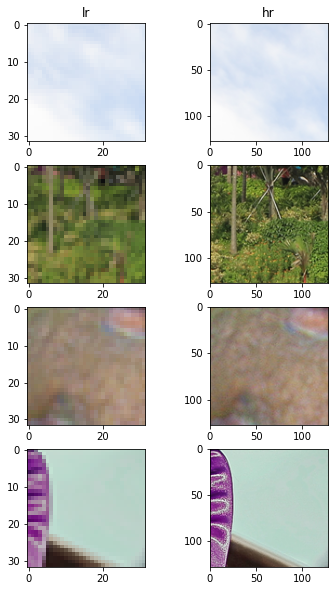

In [77]:
# Visualize Training Data
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(6,10))

for i in range(4):
    image = next(iter(train_ds))
    ax[i][0].imshow(image[0][i].numpy().astype('float32'))
    ax[i][1].imshow(image[1][i].numpy().astype('float32'))

ax[0][0].set_title("lr")
ax[0][1].set_title("hr")

print(image[0][i].numpy().shape, image[1][i].numpy().shape)

# 2. Train Model

In [78]:
def discriminator_network():
    """Discriminator Network"""
    def conv_block(x, filter=64, kernel_size=(3,3), strides=(1,1)):
        x = layers.Conv2D(filter, kernel_size, strides=strides, padding="same")(x)
        x = layers.BatchNormalization()(x)
        x = layers.LeakyReLU(alpha=0.2)(x)
        return x
    
    # Input lr image
    input_lr = tf.keras.Input(shape=(hr_image_size[0], hr_image_size[1], 3))
    x = layers.Conv2D(64, (3,3), strides=(1,1), padding="same")(input_lr)
    x = layers.LeakyReLU()(x)
    x = conv_block(x, filter=64, kernel_size=(3,3), strides=(2,2))
    x = conv_block(x, filter=128, kernel_size=(3,3), strides=(1,1))
    x = conv_block(x, filter=128, kernel_size=(3,3), strides=(2,2))
    x = conv_block(x, filter=256, kernel_size=(3,3), strides=(1,1))
    x = conv_block(x, filter=256, kernel_size=(3,3), strides=(2,2))
    x = conv_block(x, filter=512, kernel_size=(3,3), strides=(1,1))
    x = conv_block(x, filter=512, kernel_size=(3,3), strides=(2,2))
    x = layers.Flatten()(x)
    x = layers.Dense(1024)(x)
    x = layers.LeakyReLU(0.2)(x)
    # Sigmoid is not required here because we are using sigmoid when computing the loss
    output = layers.Dense(1)(x)

    model = models.Model(inputs=input_lr, outputs=output)
    return model

def generator_network(beta=0.1):
    """Generator Network"""

    # Dense Block
    def dense_block(x, n=3):
        residual = x
        for _ in range(n):
            x = layers.Conv2D(64, (3, 3), padding="same")(x)
            x = layers.LeakyReLU(0.2)(x)
            x = layers.Add()([x, residual])
            residual = layers.Add()([x, residual])
        x = layers.Conv2D(64, (3, 3), padding="same")(x)
        return x
    
    def RRDB(x):
        input = x
        residual = x
        for _ in range(3):
            residual = dense_block(x, n=3)
            residual *= beta
            residual = layers.Add()([x, residual])
            x = residual

        x *= beta
        x = layers.Add()([x, input])
        return x
    
    def upscale_block(x, factor=2):
        x = layers.Conv2D(64 * factor * factor, (9, 9), padding="same")(x)
        x = tf.nn.depth_to_space(x, factor)
        x = layers.PReLU(shared_axes=[1, 2])(x)
        return x
    
    # Input lr image
    input_lr = tf.keras.Input(shape=(None,None,3))
    input_conv = layers.Conv2D(64, (9, 9), padding="same")(input_lr)
    input_conv = layers.PReLU(shared_axes=[1, 2])(input_conv)
    x = input_conv

    # RRDB
    n = 5
    for _ in range(n):
        x = RRDB(x)
    
    x = layers.Conv2D(64, (3, 3), padding="same")(x)
    x = layers.Add()([x, input_conv])

    # Upscale
    x = upscale_block(x, factor=2)
    x = upscale_block(x, factor=2)
    
    x = layers.Conv2D(3, (9, 9), padding="same")(x)
    output = layers.Conv2D(3, (9, 9), padding="same")(x)

    model = models.Model(inputs=input_lr, outputs=output)
    return model

Get the pretrained VGG19 (2,2) network

In [79]:
# Load the VGG19 Pretrained Network without activation in the last layer
def create_custom_VGG19(nPool=2, nConv=2):
    vgg19 = tf.keras.applications.VGG19(weights='imagenet', include_top=False, input_shape=(hr_image_size[0], hr_image_size[1], 3))
    # Create a copy of target layer, because the activation functions are binded to the layers, but we want the pre activation feature maps
    i = 0
    j = 0
    layer_index = 0
    for layer in vgg19.layers:
        current_layer = layer
        if layer.__class__.__name__ == "MaxPooling2D":
            i += 1
            j = 0
        if layer.__class__.__name__ == "Conv2D":
            j += 1
        if i == nPool - 1 and j == nConv:
            break
        layer_index += 1

    num_filters = current_layer.filters
    kernel_size = current_layer.kernel_size
    padding = current_layer.padding
    target_layer = layers.Conv2D(num_filters, kernel_size, padding=padding, activation=None)

    # Create the new VGG19 model until the target layer
    custom_VGG19 = models.Sequential(vgg19.layers[:layer_index] + [target_layer])
    target_layer.set_weights(vgg19.layers[layer_index].get_weights())

    return custom_VGG19


# Create custom VGG19 model outside because tf cannot get weight in graph
custom_VGG19 = create_custom_VGG19(nPool=5, nConv=4)

In [139]:
def VGGLoss(y_true, y_pred):
    """MSE Loss between feature maps in the nConv Convolutional Layer before the nPool MaxPooling layer"""
    y_true = custom_VGG19(y_true)
    y_pred = custom_VGG19(y_pred)

    return tf.reduce_mean((y_true - y_pred) ** 2)

def adv_loss(real_output, fake_output):
    """Adversarial Loss designed to fool the discriminator"""
    real_prob = tf.sigmoid(real_output - tf.reduce_mean(fake_output))
    fake_prob = tf.sigmoid(fake_output - tf.reduce_mean(real_output))

    # # Use these two lines if you want to use a regular discriminator loss function
    # fake_loss = tf.keras.losses.BinaryCrossentropy()(tf.ones_like(fake_output), tf.sigmoid(fake_output))
    # return fake_loss

    real_loss = tf.keras.losses.BinaryCrossentropy()(tf.zeros_like(real_output), real_prob)
    fake_loss = tf.keras.losses.BinaryCrossentropy()(tf.ones_like(fake_output), fake_prob)
    
    total_loss = real_loss + fake_loss
    return total_loss

def discriminator_loss(real_output, fake_output):
    """Discriminator loss to maximize the probability of correctly classifying real and fake images"""
    real_prob = tf.sigmoid(real_output - tf.reduce_mean(fake_output))
    fake_prob = tf.sigmoid(fake_output - tf.reduce_mean(real_output))

    # # Use these two lines if you want to use a regular discriminator loss function
    # real_loss = tf.keras.losses.BinaryCrossentropy()(tf.ones_like(real_output), tf.sigmoid(real_output))
    # fake_loss = tf.keras.losses.BinaryCrossentropy()(tf.zeros_like(fake_output), tf.sigmoid(fake_output))
    
    real_loss = tf.keras.losses.BinaryCrossentropy()(tf.ones_like(real_output), real_prob)
    fake_loss = tf.keras.losses.BinaryCrossentropy()(tf.zeros_like(fake_output), fake_prob)

    total_loss = real_loss + fake_loss
    return total_loss

def hr_loss(generated_images, hr_images):
    """L1 Norm between generated image and ground truth image"""
    return tf.reduce_mean(tf.abs(generated_images - hr_images))

def psnr(y_true, y_pred):
    """Compute PSNR between two image tensors"""
    max_pixel = 1.0
    return 10 * (tf.math.log(max_pixel ** 2) - tf.math.log(tf.reduce_mean(tf.math.square(y_true - y_pred)))) / tf.math.log(10.0)

In [178]:
# Set optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)

# Create models
generator = generator_network()
discriminator = discriminator_network()

# # Save model architecture as image
# _ = tf.keras.utils.plot_model(generator, to_file=os.path.join(model_dir, 'esrgan_Generator.png'), show_shapes=True)
# _ = tf.keras.utils.plot_model(discriminator, to_file=os.path.join(model_dir, 'esrgan_Discriminator.png'), show_shapes=True)

Training Loop

In [179]:
training_history = {"gen_vgg_loss": [], "gen_adv_loss": [], "gen_hr_loss": [], "disc_loss": [], "psnr": []}
validation_history = {"gen_vgg_loss": [], "gen_adv_loss": [], "gen_hr_loss": [], "disc_loss": [], "psnr": []}


In [180]:
@tf.function
def train_step(batch, w1=5e-3, w2=1e-2):
    """
    One training step for both generator and discriminator.
    w1 and w2 are weights for adversarial loss and ground truth loss.
    """
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        lr_images, hr_images = batch
        generated_images = generator(lr_images, training=True)

        hr_output = discriminator(hr_images, training=True)
        generated_output = discriminator(generated_images, training=True)

        gen_vgg_loss = VGGLoss(hr_images, generated_images)
        gen_adv_loss = adv_loss(hr_output, generated_output)
        gen_hr_loss = hr_loss(generated_images, hr_images)
        gen_loss = gen_vgg_loss + gen_adv_loss * w1 + gen_hr_loss * w2

        disc_loss = discriminator_loss(hr_output, generated_output)

        gen_psnr = psnr(hr_images, generated_images)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # return gen_vgg_loss, 0, gen_hr_loss * w2, 0, gen_psnr
    return gen_vgg_loss, gen_adv_loss * w1, gen_hr_loss * w2, disc_loss, gen_psnr


def train(dataset, epochs, test_image=None, w1=5e-3, w2=1e-2):
    # Compute the number of batches
    ds_length = 0
    first_epoch = True

    previous_epochs_log = []

    for epoch in range(epochs):
        start = time.time()

        print(f"Running Epoch {epoch + 1}")

        current_epoch_log = []

        current_epoch_training_loss = {"gen_vgg_loss": [], "gen_adv_loss": [], "gen_hr_loss": [], "disc_loss": [], "psnr": []}
        current_epoch_validation_loss = {"gen_vgg_loss": [], "gen_adv_loss": [], "gen_hr_loss": [], "disc_loss": [], "psnr": []}

        batch_number = 0

        for image_batch in dataset:
            # if batch_number == 2:
            #     break
            if first_epoch:
                ds_length += 1
            batch_number += 1
            batch_start = time.time()

            # Train a batch of images
            gen_vgg_loss, gen_adv_loss, gen_hr_loss, disc_loss, gen_psnr = train_step(image_batch, w1, w2)

            # Record the losses
            current_epoch_training_loss["gen_vgg_loss"].append(gen_vgg_loss)
            current_epoch_training_loss["gen_adv_loss"].append(gen_adv_loss)
            current_epoch_training_loss["gen_hr_loss"].append(gen_hr_loss)
            current_epoch_training_loss["disc_loss"].append(disc_loss)
            current_epoch_training_loss["psnr"].append(gen_psnr)

            # Print progress
            if batch_number % 10 == 0:
                current_epoch_log.append(f"{batch_number}/{ds_length} Done! Time used: {time.time() - batch_start}")
                current_epoch_log.append(f"gen_vgg_loss: {gen_vgg_loss}, gen_adv_loss: {gen_adv_loss}, gen_hr_loss: {gen_hr_loss}, disc_loss: {disc_loss}, psnr: {gen_psnr}")
                print(current_epoch_log[-2])
                print(current_epoch_log[-1])
            # Save current generated image
            if batch_number % 200 == 0:
                display.clear_output(wait=True)
                # Show results and print losses after every epoch
                if test_image is not None:
                    # Produce images for the GIF as you go
                    generate_and_save_images(generator, epoch + 1, batch_number, test_image)
                for log in previous_epochs_log:
                    print(log)
                for log in current_epoch_log:
                    print(log)

        # Store epoch losses
        for key in training_history.keys():
            training_history[key].append(np.mean(np.array(current_epoch_training_loss[key])))

        # Show results and print losses after every epoch
        display.clear_output(wait=True)
        if test_image is not None:
            # Produce images for the GIF as you go
            generate_and_save_images(generator, epoch + 1, ds_length, test_image)

        previous_epochs_log.append(f"Epoch {epoch + 1} -- Time: {time.time()-start}, gen_vgg_loss: {training_history['gen_vgg_loss'][-1]}, gen_adv_loss: {training_history['gen_adv_loss'][-1]}, gen_hr_loss: {training_history['gen_hr_loss'][-1]}, disc_loss: {training_history['disc_loss'][-1]}, psnr: {training_history['psnr'][-1]}")
        for log in previous_epochs_log:
            print(log)

        # Stop incrementing ds_length because we know it now
        first_epoch = False


def generate_and_save_images(model, epoch, batch, test_input):
    for i in range(len(test_input[0])):
        predictions = model(np.expand_dims(test_input[0][i], axis=0), training=False)

        if i == 0:  # Show the image
            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
            ax[0].imshow(test_input[0][i])
            ax[1].imshow(predictions[0])
            ax[2].imshow(test_input[1][i])
            plt.show()

        # Create directory if no such directoy
        image_dir = f"images/{i}"
        if not os.path.isdir(image_dir):
            os.makedirs(image_dir)
        # Save the generated image
        path = f'{image_dir}/image_at_epoch_{epoch}_batch_{batch}.png'
        tf.keras.utils.save_img(path, predictions[0])


In [181]:
# Load the Set5 dataset
set5_hr_dir = 'data/Set5'
set5_hr_images = utils.image_array_from_directory(set5_hr_dir, downscale_factor=upscale_factor)
set5_lr_images = utils.image_array_from_directory(set5_hr_dir, downscale_factor=upscale_factor, downscale=True)

test_image = (set5_lr_images, set5_hr_images)

5 images loaded from data/Set5.
5 images downscaled by a factor of 4 from data/Set5.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


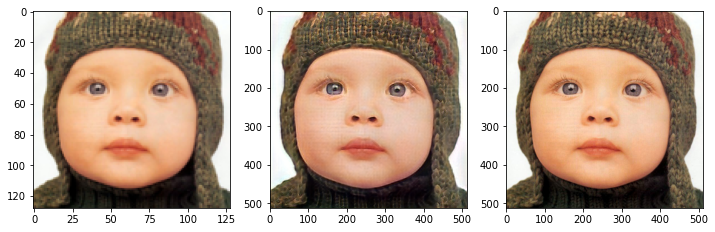

Epoch 1 -- Time: 468.1902940273285, gen_vgg_loss: 0.07428697496652603, gen_adv_loss: 0.010140519589185715, gen_hr_loss: 0.0005667971563525498, disc_loss: 0.5272698402404785, psnr: 21.2468318939209
Epoch 2 -- Time: 463.65649795532227, gen_vgg_loss: 0.0761779248714447, gen_adv_loss: 0.010038848035037518, gen_hr_loss: 0.0005600029253400862, disc_loss: 0.6366674304008484, psnr: 21.409317016601562
Epoch 3 -- Time: 463.0631082057953, gen_vgg_loss: 0.07473427802324295, gen_adv_loss: 0.010035648941993713, gen_hr_loss: 0.0005571491783484817, disc_loss: 0.6863003373146057, psnr: 21.362754821777344
Epoch 4 -- Time: 461.1000020503998, gen_vgg_loss: 0.07527270913124084, gen_adv_loss: 0.009304600767791271, gen_hr_loss: 0.0005650984239764512, disc_loss: 0.6722123622894287, psnr: 21.382217407226562
Epoch 5 -- Time: 462.77696418762207, gen_vgg_loss: 0.07447933405637741, gen_adv_loss: 0.009482955560088158, gen_hr_loss: 0.0005381574155762792, disc_loss: 0.6833792328834534, psnr: 21.56047248840332
Epoch 6

In [182]:
# Keep on training a trained model
generator.load_weights(os.path.join(model_dir, 'esrgan54_x4.h5'))
discriminator.load_weights(os.path.join(model_dir, 'esrgan54_discriminator_x4.h5'))

epochs = 10
# train(train_ds, epochs, test_image, w1=0, w2=1e-2)
# train(train_ds, epochs, test_image, w1=5e-3, w2=1)
train(train_ds, epochs, test_image, w1=5e-3, w2=1e-2)

In [183]:
# Save model
generator.save_weights(os.path.join(model_dir, 'esrgan54_x4.h5'))
discriminator.save_weights(os.path.join(model_dir, 'esrgan54_discriminator_x4.h5'))

[]

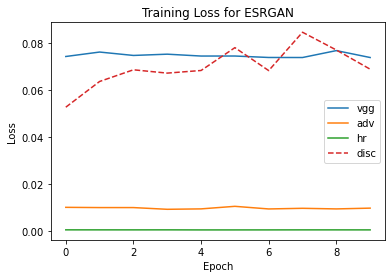

In [184]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(training_history["gen_vgg_loss"], label='vgg')
ax.plot(training_history["gen_adv_loss"], label='adv')
ax.plot(training_history["gen_hr_loss"], label='hr')
ax.plot(np.array(training_history["disc_loss"]) / 10, label='disc', linestyle="--")

ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_title("Training Loss for ESRGAN")
ax.legend()
ax.plot()

# 3. Evaluation

In [185]:
generator.load_weights(os.path.join(model_dir, 'esrgan54_x4.h5'))

Because we are going to evaluate on images with different sizes, we cannot load them as a dataset like the training and validation dataset above.  
We need to load the images to numpy arrays ourselves, and then predict them one by one.  

Some datasets only provide HR images, so we need to downscale it ourselves.  
Also, an upscale function is implemented for upscaling LR images with bicubic interpolation for comparison.

In [186]:
def rescale(image, scale, downscale=False):
    image = tf.keras.preprocessing.image.array_to_img(image * 255)
    if downscale:
        image = utils.downscale_image(image, scale)
    else:
        image = utils.upscale_image(image, scale)
    image = tf.keras.preprocessing.image.img_to_array(image)
    return image / 255

### Validation Set

In [187]:
# Load the DIV2K validation dataset
val_hr_dir = 'data/DIV2K/validation/HR'
# val_lr_dir = 'data/DIV2K/validation/LRx4_unknown' # This is more difficult than bicubic downgrade
val_hr_images = utils.image_array_from_directory(val_hr_dir, downscale_factor=upscale_factor, limit=5)
val_lr_images = utils.image_array_from_directory(val_hr_dir, downscale_factor=upscale_factor, downscale=True, limit=5)

# Upscale with bicubic interpolation as baseline
bicubic_val_lr_images = []
for image in val_lr_images:
    image = tf.keras.preprocessing.image.array_to_img(image * 255)
    image = utils.upscale_image(image, upscale_factor)
    image = tf.keras.preprocessing.image.img_to_array(image)
    bicubic_val_lr_images.append(image / 255)
    

5 images loaded from data/DIV2K/validation/HR.
5 images downscaled by a factor of 4 from data/DIV2K/validation/HR.


In [188]:
# Make predictions on validation set
predictions = []
for image in val_lr_images:
    hr = generator.predict(np.expand_dims(image, axis=0))[0]
    hr = tf.clip_by_value(hr, 0, 1)
    predictions.append(hr)
    if len(predictions) > 5:
        break

psnr_bicubic = []
psnr_esrgan = []
for i in range(len(predictions)):
    psnr_bicubic.append(tf.image.psnr(bicubic_val_lr_images[i], val_hr_images[i], 1.0).numpy())
    psnr_esrgan.append(tf.image.psnr(predictions[i], val_hr_images[i], 1.0).numpy())
psnr_bicubic = np.array(psnr_bicubic)
psnr_esrgan = np.array(psnr_esrgan)

print("PSNR (Bicubic):", np.average(psnr_bicubic))
print("PSNR (ESRGAN):", np.average(psnr_esrgan))

2022-01-29 08:27:23.420570: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-29 08:27:33.194422: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-29 08:27:39.887749: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


PSNR (Bicubic): 28.847467
PSNR (ESRGAN): 24.135391


Text(0.5, 1.0, 'Ground Truth')

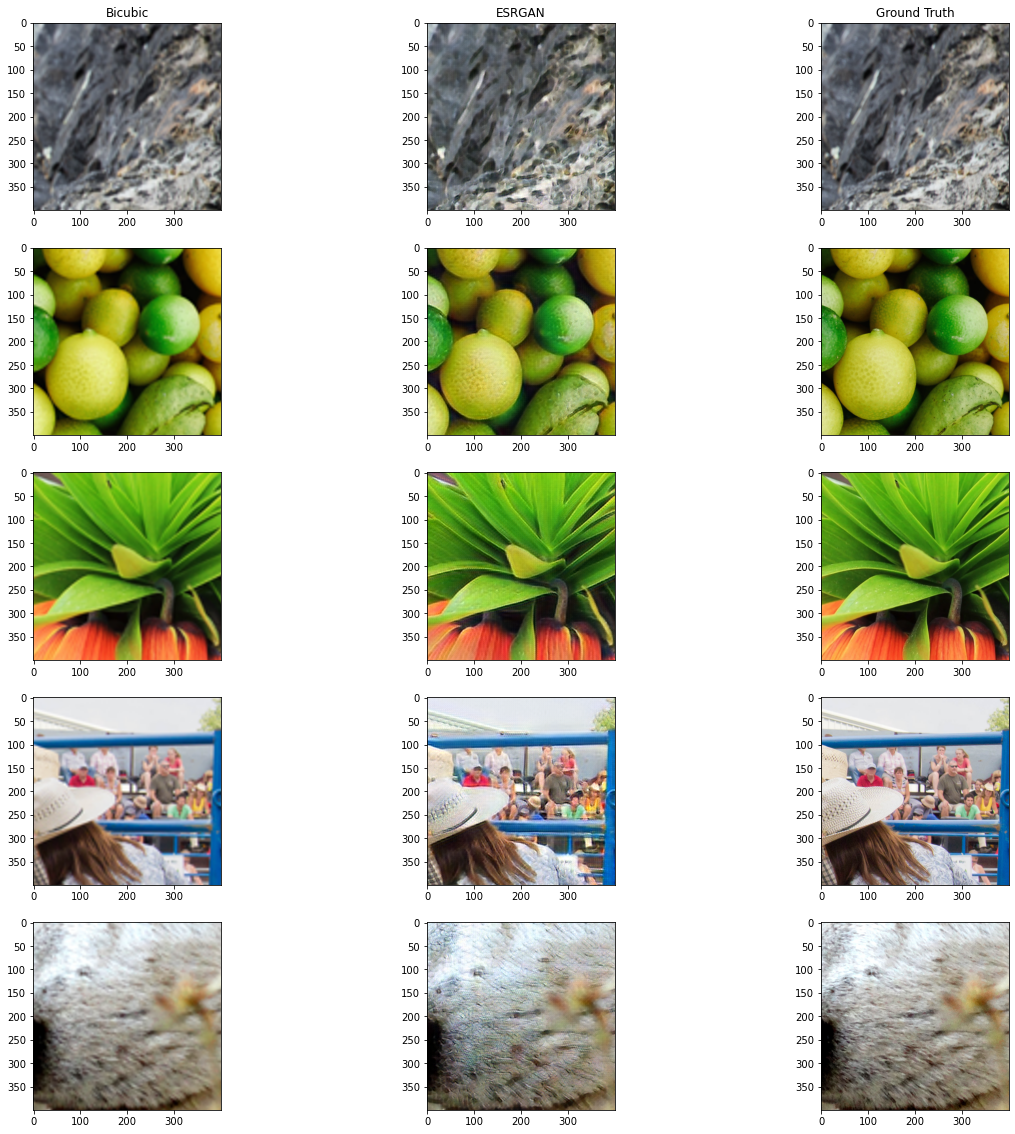

In [189]:
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(20, 20))

plot_size = 400
for i in range(5):
    x = np.random.randint(0, val_hr_images[i].shape[0]-plot_size)
    y = np.random.randint(0, val_hr_images[i].shape[1]-plot_size)
    ax[i][0].imshow(bicubic_val_lr_images[i][x:x+plot_size, y:y+plot_size,:])
    ax[i][1].imshow(predictions[i][x:x+plot_size, y:y+plot_size,:])
    ax[i][2].imshow(val_hr_images[i][x:x+plot_size, y:y+plot_size,:])

ax[0][0].set_title("Bicubic")
ax[0][1].set_title("ESRGAN")
ax[0][2].set_title("Ground Truth")

### Set5

In [190]:
# Load the Set5 dataset
set5_hr_dir = 'data/Set5'
set5_hr_images = utils.image_array_from_directory(set5_hr_dir, downscale_factor=upscale_factor)
set5_lr_images = utils.image_array_from_directory(set5_hr_dir, downscale_factor=upscale_factor, downscale=True)

# Bicubic interpolation for comparison
bicubic_set5_lr_images = []
for image in set5_lr_images:
    image = tf.keras.preprocessing.image.array_to_img(image * 255)
    image = utils.upscale_image(image, upscale_factor)
    image = tf.keras.preprocessing.image.img_to_array(image)
    bicubic_set5_lr_images.append(image / 255)

5 images loaded from data/Set5.
5 images downscaled by a factor of 4 from data/Set5.


In [191]:
# Make predictions on Set5
predictions = []
for image in set5_lr_images:
    hr = generator.predict(np.expand_dims(image, axis=0))[0]
    hr = tf.clip_by_value(hr, 0, 1)
    predictions.append(hr)

psnr_bicubic = []
psnr_esrgan = []
for i in range(len(predictions)):
    psnr_bicubic.append(tf.image.psnr(bicubic_set5_lr_images[i], set5_hr_images[i], 1.0).numpy())
    psnr_esrgan.append(tf.image.psnr(predictions[i], set5_hr_images[i], 1.0).numpy())
psnr_bicubic = np.array(psnr_bicubic)
psnr_esrgan = np.array(psnr_esrgan)

print("PSNR (Bicubic):", np.average(psnr_bicubic), psnr_bicubic)
print("PSNR (ESRGAN):", np.average(psnr_esrgan), psnr_esrgan)

2022-01-29 08:27:50.315902: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


PSNR (Bicubic): 26.59675 [30.416115 28.068218 20.456728 28.963413 25.079266]
PSNR (ESRGAN): 22.560986 [24.902878 23.616096 17.729124 26.076258 20.480566]


Text(0.5, 1.0, 'Ground Truth')

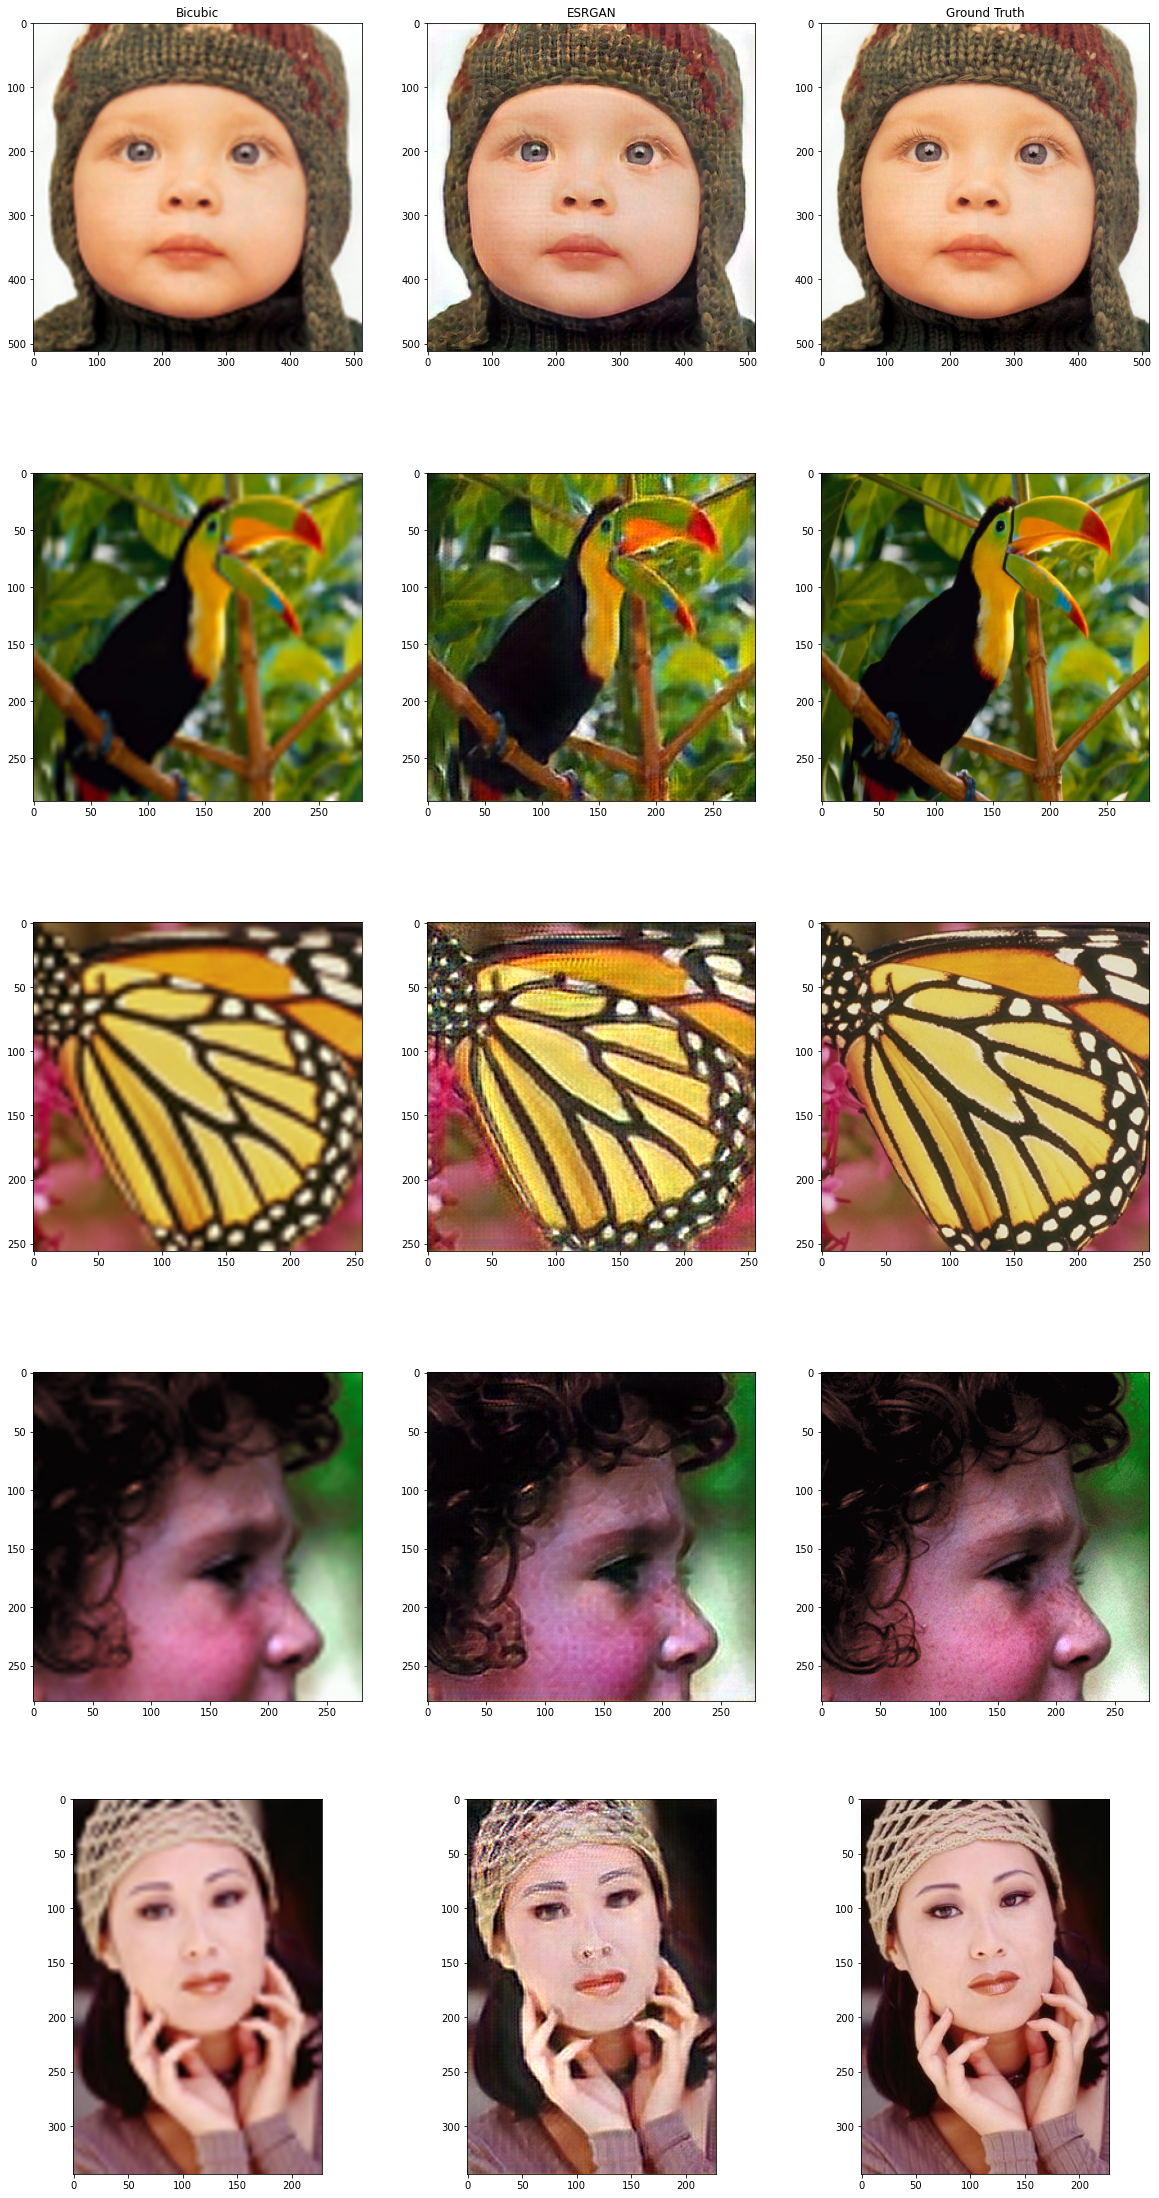

In [192]:
fig, ax = plt.subplots(nrows=5, ncols=3, figsize=(20, 40))

for i in range(5):
    ax[i][0].imshow(bicubic_set5_lr_images[i])
    ax[i][1].imshow(predictions[i])
    ax[i][2].imshow(set5_hr_images[i])

ax[0][0].set_title("Bicubic")
ax[0][1].set_title("ESRGAN")
ax[0][2].set_title("Ground Truth")

### Set14

In [193]:
# Load the Set14 dataset
set14_hr_dir = 'data/Set14'
set14_hr_images = utils.image_array_from_directory(set14_hr_dir, downscale_factor=upscale_factor)
set14_lr_images = utils.image_array_from_directory(set14_hr_dir, downscale_factor=upscale_factor, downscale=True)

# Bicubic interpolation for comparison
bicubic_set14_lr_images = []
for image in set14_lr_images:
    image = tf.keras.preprocessing.image.array_to_img(image * 255)
    image = utils.upscale_image(image, upscale_factor)
    image = tf.keras.preprocessing.image.img_to_array(image)
    bicubic_set14_lr_images.append(image / 255)

14 images loaded from data/Set14.
14 images downscaled by a factor of 4 from data/Set14.


In [194]:
# Make predictions on Set14
predictions = []
for image in set14_lr_images:
    hr = generator.predict(np.expand_dims(image, axis=0))[0]
    hr = tf.clip_by_value(hr, 0, 1)
    predictions.append(hr)

psnr_bicubic = []
psnr_esrgan = []
for i in range(len(predictions)):
    psnr_bicubic.append(tf.image.psnr(bicubic_set14_lr_images[i], set14_hr_images[i], 1.0).numpy())
    psnr_esrgan.append(tf.image.psnr(predictions[i], set14_hr_images[i], 1.0).numpy())
psnr_bicubic = np.array(psnr_bicubic)
psnr_esrgan = np.array(psnr_esrgan)

print("PSNR (Bicubic):", np.average(psnr_bicubic))
print("PSNR (ESRGAN):", np.average(psnr_esrgan))

PSNR (Bicubic): 23.864874
PSNR (ESRGAN): 21.063843


Text(0.5, 1.0, 'Ground Truth')

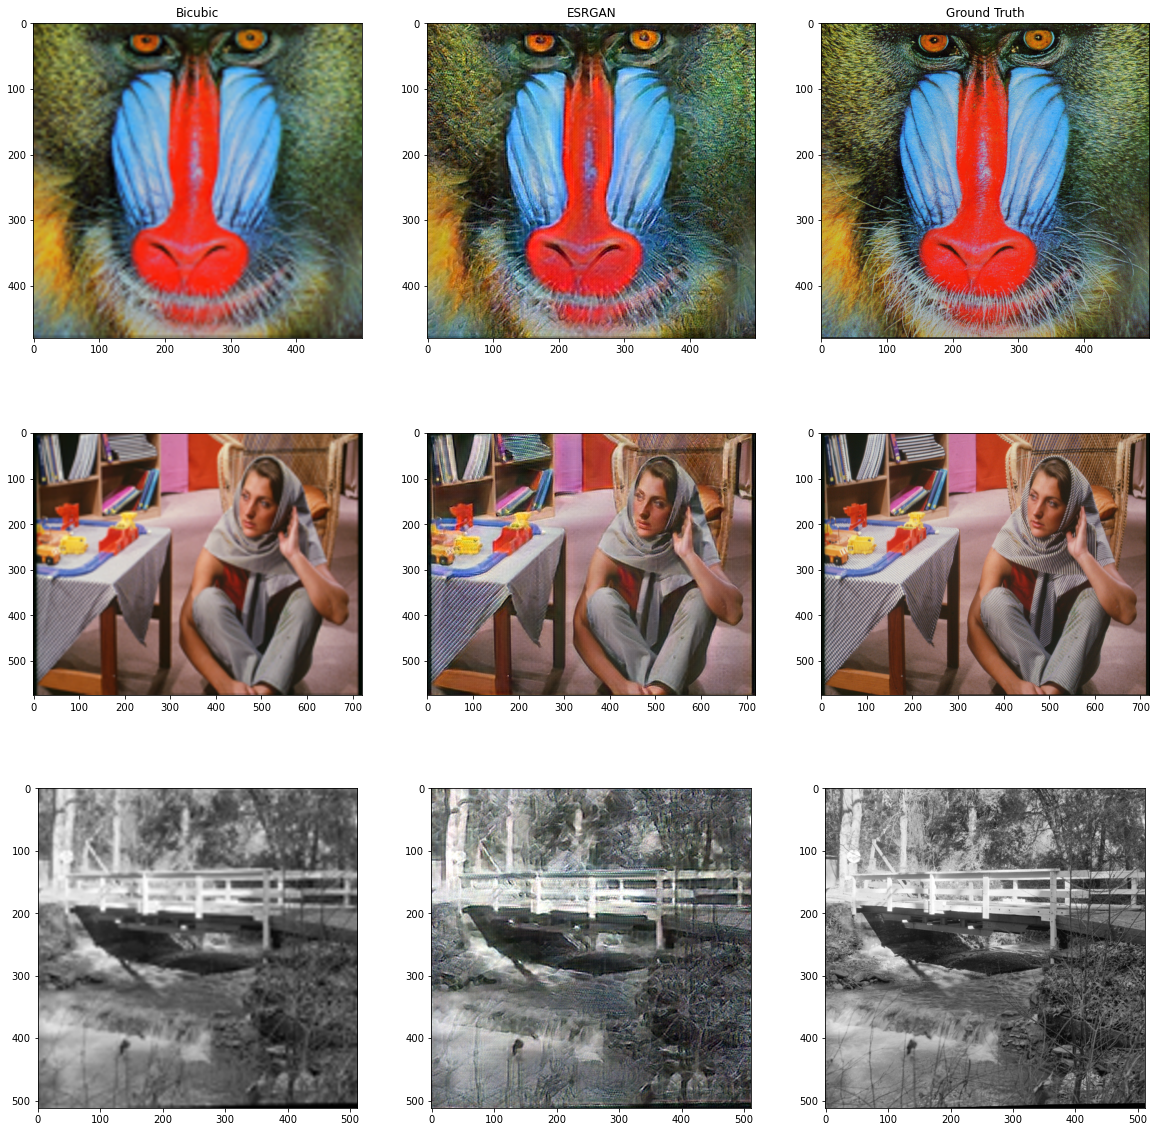

In [195]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20, 20))

for i in range(3):
    ax[i][0].imshow(bicubic_set14_lr_images[i])
    ax[i][1].imshow(predictions[i])
    ax[i][2].imshow(set14_hr_images[i])

ax[0][0].set_title("Bicubic")
ax[0][1].set_title("ESRGAN")
ax[0][2].set_title("Ground Truth")

## Visualizing Layer Outputs

In [196]:
import glob
import imageio

In [197]:
anim_file = 'esrgan_set5_0.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('images/0/image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [198]:
# from IPython.display import Image
# Image("esrgan_set5_0.gif")